In [1]:
import os
import glob
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm, tqdm_notebook
import tools
%matplotlib notebook

### komentarji:
    
    - omejitev števila točk (urejeno glede na "moč" ujemanja)
    - log napak projekcije
    - boljša triangulacija!
    - unikaten identifier vsake matrike ``[R|t]`` (da niso naslavljane po indeksu)

In [2]:
SCALE = 0.2
MATCH_RATIO = 0.85  # more -> LESS matches rejected
NFEV = 10000         # maximum number of least_squares iterations
MODE = 'ORB'        # feature extraction algorithm

In [3]:
d_max = 1       # (for RANSAC) maximum distance from epipolar line above which a point is considered an outlier
alpha = 0.995   # (RANSAC) desired probability, that the estimated F matrix is correct

In [4]:
path = 'images/kip'
path_calib = 'kalibracija/redmi'
images = glob.glob(os.path.join(path, '*.JPG'))[1:-1]
calibration_images = glob.glob(os.path.join(path_calib, '*.JPG'))

### main loop

In [ ]:
beginning_time = time.perf_counter()

In [ ]:
scene = {}
K, distCoeffs = tools.calibrate_camera(calibration_images, (6, 4), (40, 40), scale=0.5)
N = len(images)

In [ ]:
after_calibration = time.perf_counter()

--- BUNDLE ADJUSTMENT ---
parameters:	729 
cost before BA:	4974467670.81
optimization summary:
	cost 9476.30112
	nfev 10230.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	18952.60 



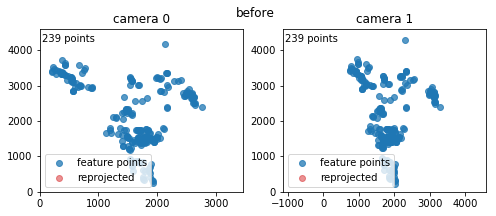

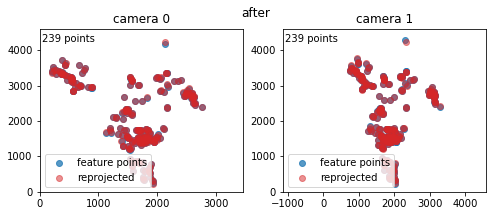

--- BUNDLE ADJUSTMENT ---
parameters:	654 
cost before BA:	3361283258.20
optimization summary:
	cost 84599.14258
	nfev 10492.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	169198.29 



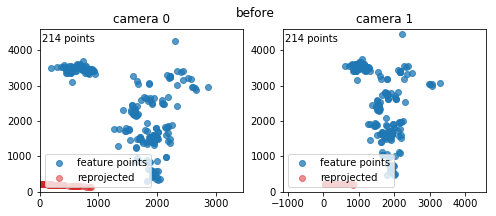

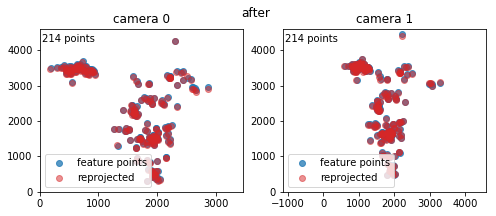


--- seqential BA, image pair 1 ---
--- BUNDLE ADJUSTMENT ---
parameters:	1320 
cost before BA:	901834783.98
optimization summary:
	cost 30540.79041
	nfev 10575.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	61081.58 



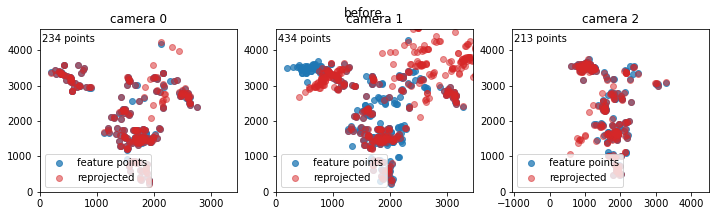

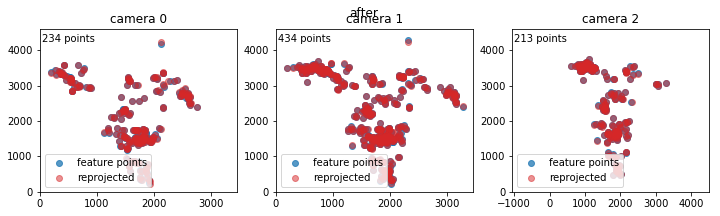

--- BUNDLE ADJUSTMENT ---
parameters:	612 
cost before BA:	3690018002.48
optimization summary:
	cost 5944.35250
	nfev 10433.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	11888.70 



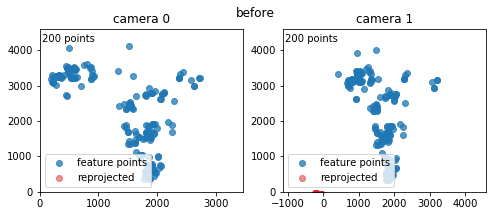

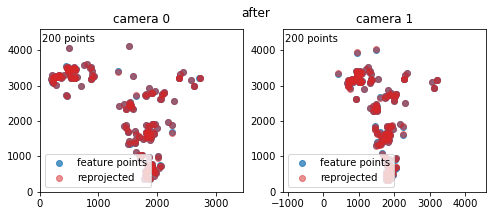


--- seqential BA, image pair 2 ---
--- BUNDLE ADJUSTMENT ---
parameters:	1890 
cost before BA:	584731942.14
optimization summary:
	cost 77516.71457
	nfev 11352.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	155033.43 



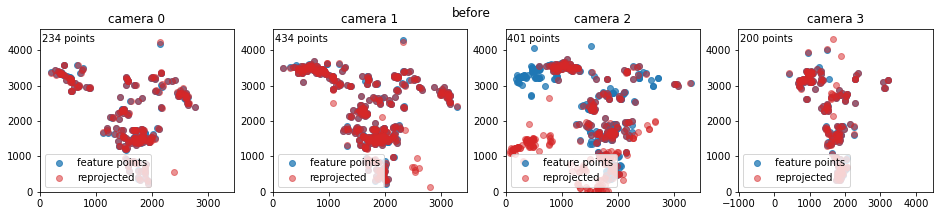

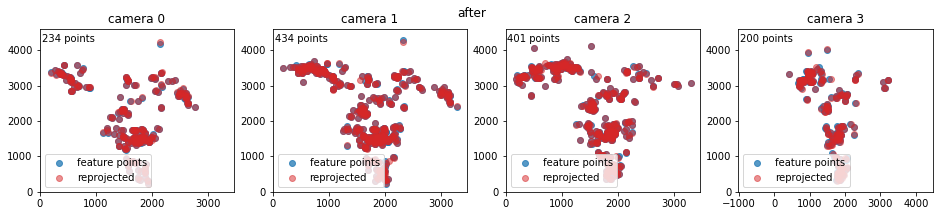

--- BUNDLE ADJUSTMENT ---
parameters:	729 
cost before BA:	4077224586.85
optimization summary:
	cost 697566.56083
	nfev 10229.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	1395133.12 



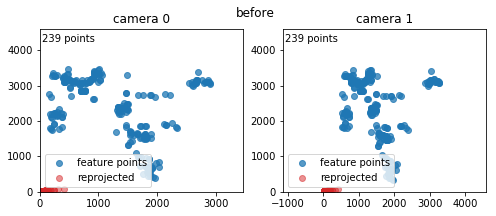

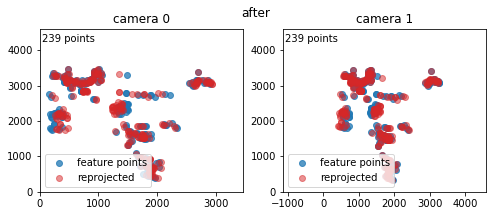


--- seqential BA, image pair 3 ---
--- BUNDLE ADJUSTMENT ---
parameters:	2457 
cost before BA:	637107182.43
optimization summary:
	cost 2795882.72916
	nfev 12296.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	5591765.46 



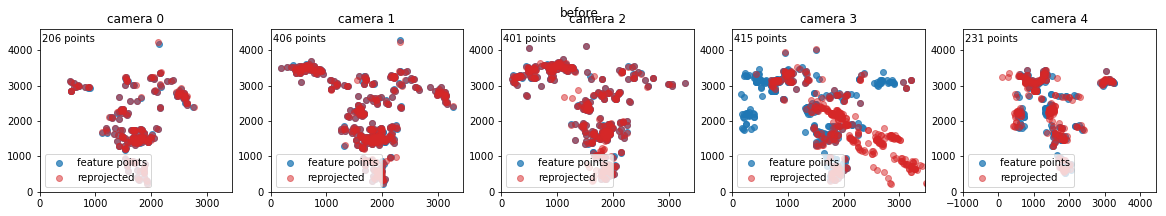

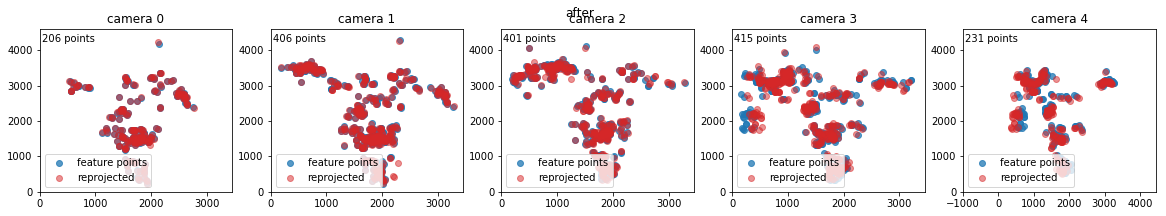

--- BUNDLE ADJUSTMENT ---
parameters:	702 
cost before BA:	3924370911.63
optimization summary:
	cost 19528.60951
	nfev 10556.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	39057.22 



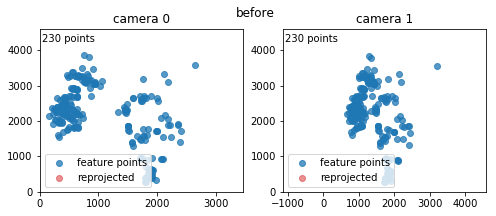

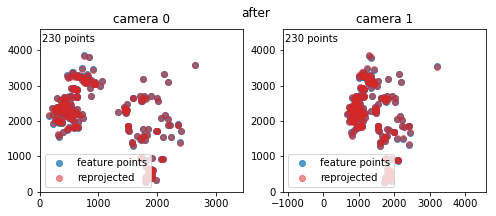


--- seqential BA, image pair 4 ---
--- BUNDLE ADJUSTMENT ---
parameters:	3024 
cost before BA:	431781259.61
optimization summary:
	cost 691388.33208
	nfev 12105.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	1382776.66 



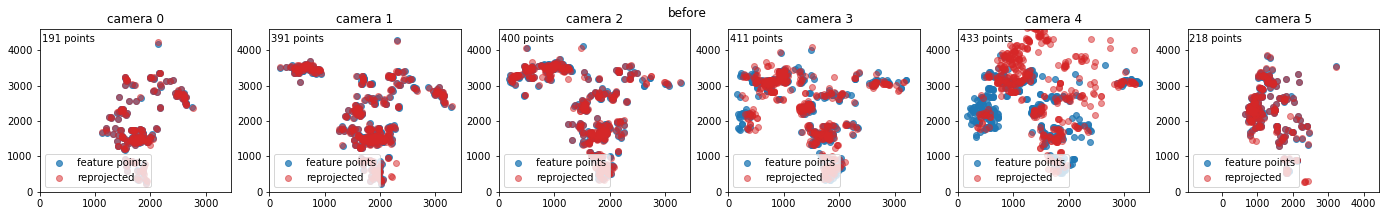

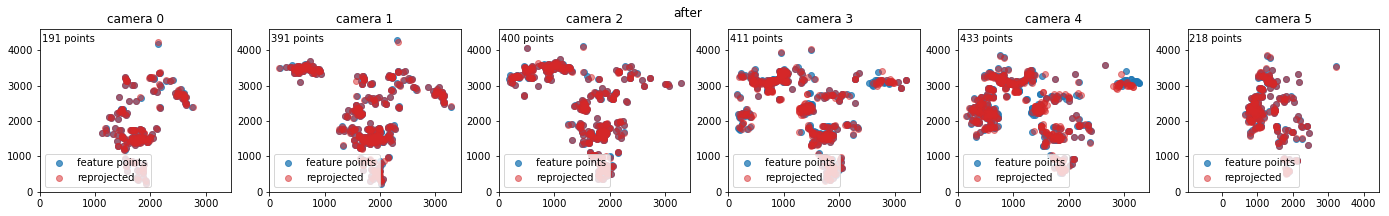

--- BUNDLE ADJUSTMENT ---
parameters:	432 
cost before BA:	1494957112.80
optimization summary:
	cost 14473.95476
	nfev 10410.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	28947.91 



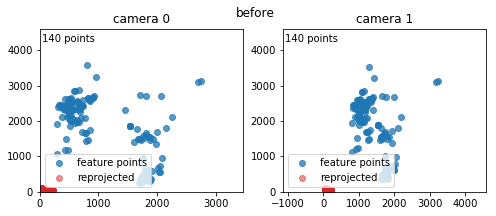

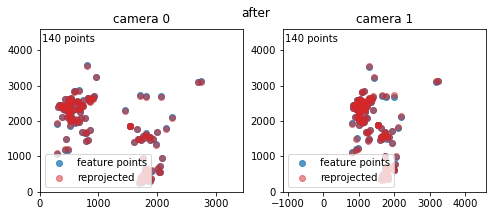


--- seqential BA, image pair 5 ---
--- BUNDLE ADJUSTMENT ---
parameters:	3432 
cost before BA:	587700235.46
optimization summary:
	cost 1354252.73197
	nfev 10304.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	2708505.46 



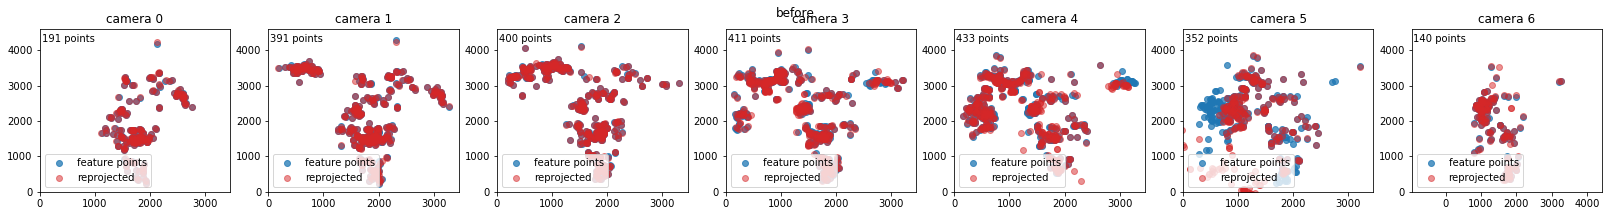

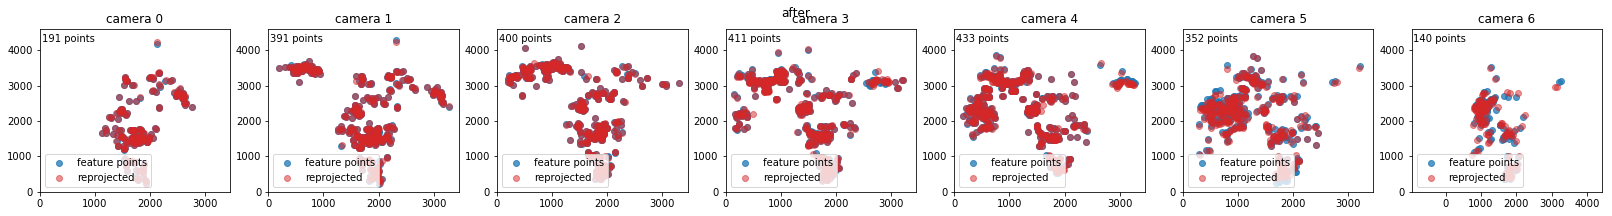

--- BUNDLE ADJUSTMENT ---
parameters:	672 
cost before BA:	3780105355.46
optimization summary:
	cost 219823.96580
	nfev 10104.00000
	status 0
	message The maximum number of function evaluations is exceeded.
cost after BA:	439647.93 



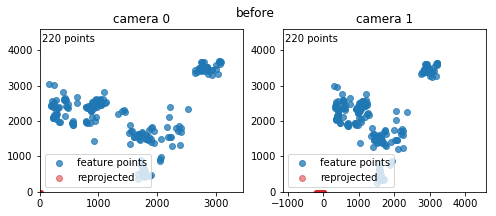

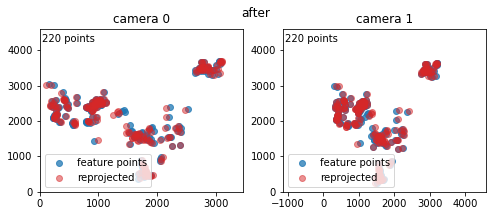


--- seqential BA, image pair 6 ---
--- BUNDLE ADJUSTMENT ---
parameters:	4047 
cost before BA:	11769480520.59


In [ ]:
plot = False
%matplotlib inline

for i in tqdm_notebook(range(N - 1)):
    
    if i == 0:
        last_Rt = None
        im1 = tools.read_bw(images[i])
        im2 = tools.read_bw(images[i+1])
        Rt1, Rt2, p1, p2 = tools.get_camera_matrices(im1, im2, K, last_Rt, d_max=d_max, alpha=alpha,
                                           scale=SCALE, match_ratio=MATCH_RATIO, mode=MODE)
    else:
        im1 = im2
        im2 = tools.read_bw(images[i+1])
        Rt1, Rt2, p1, p2 = tools.get_camera_matrices(im1, im2, K, last_Rt,# cloud, i, distCoeffs, 
                                            d_max=d_max, alpha=alpha, scale=SCALE, match_ratio=MATCH_RATIO, mode=MODE)

    last_Rt = Rt2
    P1 = K.dot(Rt1)
    P2 = K.dot(Rt2)
    
    points3D = []
    for x1, x2 in zip(p1, p2):
        X = tools.triangulate_lsq(tools.to_homogenous(x1), tools.to_homogenous(x2), P1, P2)
        points3D.append(tools.Point3D(X, x1, x2, i, i+1))
    
    if i == 0:
        cloud = tools.Scene([Rt1, Rt2], points3D, K, im1.shape, debug=True)
        cloud.bundle_adjustment(ftol=1e-8, max_nfev=NFEV, max_sd_dist=2, X_only=False)
    else:
        pair = tools.Scene([Rt1, Rt2], points3D, K, im1.shape, frame_offset=i, debug=True)
        pair.bundle_adjustment(ftol=1e-8, max_nfev=NFEV, max_sd_dist=2, X_only=False)
        cloud.add_next_pair(pair)
        
        # Sequential bundle adjustment
        print('\n--- seqential BA, image pair {:d} ---'.format(i))
        cloud.bundle_adjustment(ftol=1e-6, max_nfev=NFEV, max_sd_dist=2, X_only=False)
        
    if plot:# and i % (N//2) == 0:
        print('---- slika {:d} ----\n'.format((i+1)))
        cloud.render()
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 3))
        ax[0].imshow(im1, cmap='gray')
        ax[0].scatter(p1[:, 0], p1[:, 1])
        ax[1].imshow(im2, cmap='gray')
        ax[1].scatter(p2[:, 0], p2[:, 1])
        plt.show()

In [ ]:
main_loop_time = time.perf_counter()

In [ ]:
#X, Y, Z = cloud.render()

In [ ]:
%matplotlib
X, Y, Z = cloud.render(cameras=True)

In [ ]:
cloud.bundle_adjustment(ftol=1e-5, max_nfev=5000)
#X, Y, Z = cloud.render(cameras=True, openGL=True)

In [ ]:
end_time = time.perf_counter()

In [ ]:
total = end_time - beginning_time 
calibration = after_calibration - beginning_time
loop = main_loop_time - after_calibration
ba = end_time - main_loop_time
print('total time:\t{:.0f} min {:.1f} s'.format(total // 60, total % 60))
print('calib. time:\t{:.0f} min {:.1f} s'.format(loop // 60, calibration % 60))
print('loop time:\t{:.0f} min {:.1f} s'.format(loop // 60, loop % 60))
print('ba time:\t{:.0f} min {:.1f} s'.format(ba // 60, ba % 60))

In [ ]:
name = path.replace('/', '_').replace('\\', 'n')
name += '_sequential_final_BA'
cloud.pickle_save(name=name, path='results', mode='scene')

In [ ]:
#cloud.render(openGL=True, cameras=True)